In [1]:
import matplotlib.pyplot as plt
#import seaborn as sns
import time
import copy
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
#
import torch
import torch.nn as nn
import torch.nn.functional as f
#
import mnist1d
from mnist1d.data import get_dataset_args, get_dataset
from mnist1d.utils import plot_signals
from solvers import get_optimizer
from models import *

In [2]:
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cpu


## Load Data

In [3]:
args = get_dataset_args()
data = get_dataset(args, path='./mnist1d_data.pkl', download=True) # This is the default setting

Saving to ./mnist1d_data.pkl
Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...


In [4]:
x = data["x"]
t = data["t"]
y = data["y"]

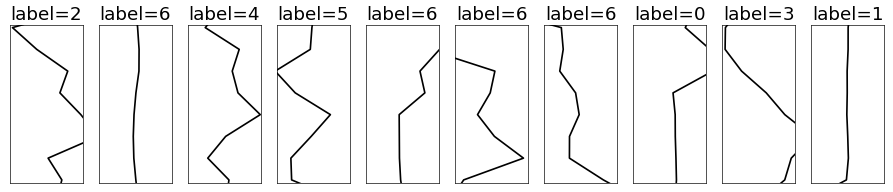

In [5]:
fig = plot_signals(x, t, labels=y, args=args, ratio=2.2, do_transform=True)

## Solvers

In [8]:
solvers = [
    {"optimizer": "sgd",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
         "momentum": 0.9
     }},
    {"optimizer": "adam",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "yogi",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "shampoo",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
         "momentum": 0.9
     }},
    {"optimizer": "swats",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "sgdw",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
         "momentum": 0.9
     }},
    {"optimizer": "sgdp",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
         "momentum": 0.9
     }},
    {"optimizer": "rangerva",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "rangerqh",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "ranger",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "radam",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "qhm",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
         "momentum": 0.9
     }},
    {"optimizer": "qhadam",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "pid",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
         "momentum": 0.9
     }},
    {"optimizer": "novograd",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "lamb",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "diffgrad",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "aggmo",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "adamp",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "adabound",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "adabelief",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
    {"optimizer": "accsgd",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }},
]

In [6]:
solvers = [
    {"optimizer": "sgd",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
         "momentum": 0.9
     }},
    {"optimizer": "ranger",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }}
]

In [7]:
solvers = [
    {"optimizer": "ranger",
     "optimizer_args": {
         "lr": 1e-2,
         "weight_decay": 0,
     }}
]

## Train

In [8]:
batch_size = 4000
total_steps = 800
print_every = 25
eval_every = 2
device = DEVICE
seed = 42

In [9]:
def accuracy(model, inputs, targets):
    preds = model(inputs).argmax(-1).cpu().numpy()
    targets = targets.cpu().numpy().astype(np.float32)
    return 100*sum(preds==targets)/len(targets)

def train_model(dataset, model, optimizer):
    criterion = nn.CrossEntropyLoss()

    results = {'train_losses':[], 'test_losses':[],'train_acc':[],'test_acc':[]}
    t0 = time.time()
    for step in range(total_steps+1):
        bix = (step*batch_size)%len(x_train) # batch index
        x, y = x_train[bix:bix+batch_size], y_train[bix:bix+batch_size]
      
        loss = criterion(model(x), y)
        loss.backward() ; optimizer.step() ; optimizer.zero_grad()

        if eval_every > 0 and step % eval_every == 0: # evaluate the model
            with torch.no_grad():
                test_loss = criterion(model(x_test), y_test)
                train_loss = criterion(model(x_train), y_train)
                results['train_losses'].append(train_loss.item())
                results['test_losses'].append(test_loss.item())
                results['train_acc'].append(accuracy(model, x_train, y_train))
                results['test_acc'].append(accuracy(model, x_test, y_test))

        if step > 0 and step % print_every == 0: # print out training progress
            t1 = time.time()
            print("step {}, dt {:.2f}s, train_loss {:.3e}, test_loss {:.3e}, train_acc {:.1f}, test_acc {:.1f}"
                  .format(step, t1-t0, loss.item(), results['test_losses'][-1], \
                  results['train_acc'][-1], results['test_acc'][-1]))
            t0 = t1
    return results

In [10]:
criterion = nn.CrossEntropyLoss()

x_train, x_test = torch.Tensor(data['x'])[:800, :], torch.Tensor(data['x_test'])[:200, :]
y_train, y_test = torch.LongTensor(data['y'])[:800], torch.LongTensor(data['y_test'])[:200]
#
x_train, x_test, y_train, y_test = [v.to(DEVICE) for v in [x_train, x_test, y_train, y_test]]


In [11]:
solvers

[{'optimizer': 'ranger', 'optimizer_args': {'lr': 0.01, 'weight_decay': 0}}]

In [12]:
x_train.shape, x_test.shape

(torch.Size([800, 40]), torch.Size([200, 40]))

## Train MLP

In [13]:
all_results = {}
for params in solvers:
    print(params["optimizer"])
    model = MLPBase(input_size=40, output_size=10, hidden_size=20)
    model = model.to(DEVICE)
    optimizer = get_optimizer(params["optimizer"], model, params["optimizer_args"])
    result = train_model(data, model, optimizer)
    all_results[params["optimizer"]] = result

ranger
Initialized MLPBase model with 1030 parameters


C:\Users\Soeren\Anaconda3\lib\site-packages\pytorch_ranger\ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


step 25, dt 0.27s, train_loss 2.296e+00, test_loss 2.303e+00, train_acc 10.4, test_acc 14.0
step 50, dt 0.20s, train_loss 2.206e+00, test_loss 2.214e+00, train_acc 17.8, test_acc 18.5
step 75, dt 0.21s, train_loss 2.081e+00, test_loss 2.113e+00, train_acc 26.2, test_acc 27.0
step 100, dt 0.19s, train_loss 1.924e+00, test_loss 1.971e+00, train_acc 30.8, test_acc 26.5
step 125, dt 0.19s, train_loss 1.780e+00, test_loss 1.872e+00, train_acc 33.0, test_acc 27.0
step 150, dt 0.21s, train_loss 1.694e+00, test_loss 1.820e+00, train_acc 36.9, test_acc 31.0
step 175, dt 0.19s, train_loss 1.605e+00, test_loss 1.797e+00, train_acc 40.4, test_acc 31.5
step 200, dt 0.21s, train_loss 1.533e+00, test_loss 1.793e+00, train_acc 44.2, test_acc 29.5
step 225, dt 0.17s, train_loss 1.470e+00, test_loss 1.800e+00, train_acc 46.2, test_acc 29.5
step 250, dt 0.21s, train_loss 1.410e+00, test_loss 1.808e+00, train_acc 48.9, test_acc 33.0
step 275, dt 0.18s, train_loss 1.354e+00, test_loss 1.832e+00, train_acc 

In [14]:
with open("cnn_results.pkl", "wb") as file:
    pickle.dump(all_results, file)

with open("cnn_results.pkl", "rb") as file:
    results = pickle.load(file)

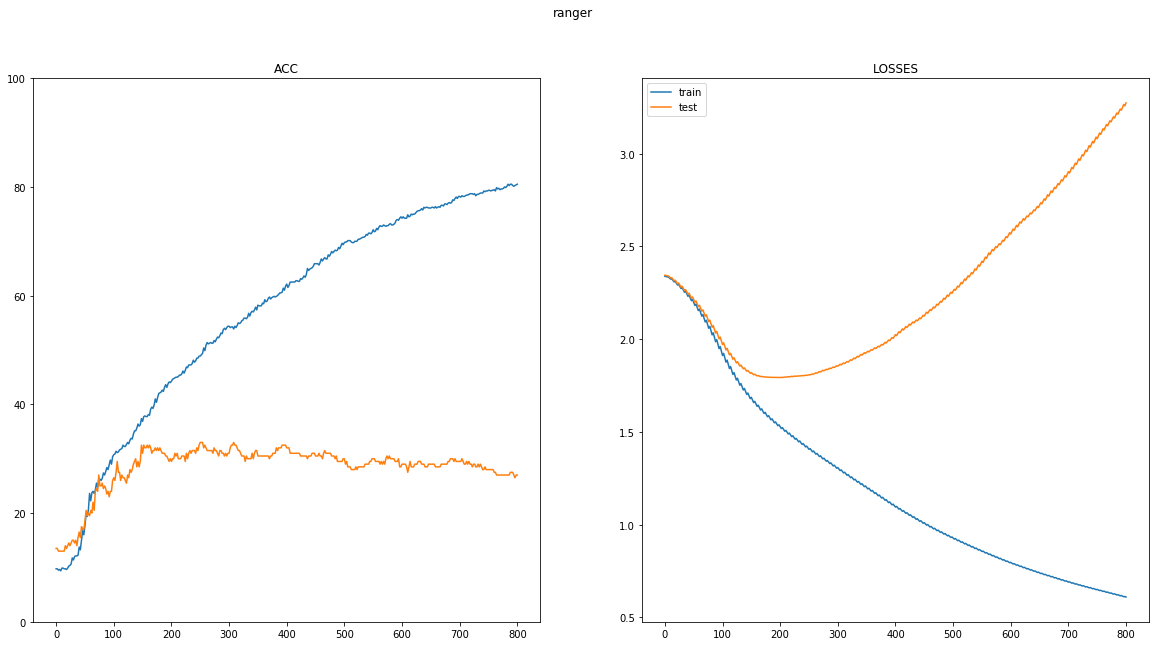

In [15]:
for solver in all_results.keys():
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    t = range(0, total_steps+1, eval_every)
    axs[0].plot(t, all_results[solver]["train_acc"], label="train")
    axs[0].plot(t, all_results[solver]["test_acc"], label="test")
    axs[0].set_title("ACC")
    #axs[0].set_yscale('log')
    axs[0].set_ylim(0, 100)
    
    t = range(0, total_steps+1, eval_every)
    axs[1].plot(t, all_results[solver]["train_losses"], label="train")
    axs[1].plot(t, all_results[solver]["test_losses"], label="test")
    axs[1].set_title("LOSSES")
    #axs[1].set_yscale('log')
    fig.suptitle(solver)
    plt.legend()
    plt.show()